In [106]:
import pandas as pd
import datetime as dt
from wordcloud import WordCloud, STOPWORDS 
import nltk
import matplotlib.pyplot as plt 



In [2]:
df = pd.read_csv("Reddit_Election_Posts.csv")

In [5]:
def get_date(created):
    return dt.datetime.fromtimestamp(created)

In [29]:
df['url'].astype(str).str[0:]

0        https://www.reddit.com/r/Liberal/comments/9m2d...
1        https://www.reddit.com/r/Liberal/comments/9m2f...
2        https://www.reddit.com/r/Liberal/comments/9m2i...
3        https://www.reddit.com/r/Liberal/comments/9m2k...
4        https://www.reddit.com/r/Liberal/comments/9m3y...
                               ...                        
27825    http://www.openmarket.org/2012/07/10/quotas-li...
27826    http://www.marketplace.org/topics/wealth-pover...
27827    http://www.denverpost.com/politics-national/20...
27828    http://thoughtcatalog.com/2012/american-discor...
27829    https://www.reddit.com/r/moderatepolitics/comm...
Name: url, Length: 27830, dtype: object

In [26]:
#get posted date, add to df
_timestamp = df["created"].apply(get_date)
df = df.assign(timestamp = _timestamp)

#find election year
df['election year']=df['year'].astype(str).str[0:4]

In [74]:
#find url site

url_agency = []
for x in df['url']:
    if "www." in x:
        y=(x.find("."))
        z=x.find(".",y+1)
        url_agency.append(x[y+1:z])
    
    elif "redd.it" in x:
        url_agency.append('reddit')
    elif "https://" in x:
        z=x.find(".",8)
        url_agency.append(x[8:z])

        
    else:
        z=x.find(".",7)
        url_agency.append(x[7:z])

df['url agency']=url_agency

In [72]:
df.head(10)

,subreddit,year,title,score,id,url,comms_num,created,body,timestamp,election year,url agency
0,Liberal,2018-11-06,Changing party affiliation in response to Kave...,13,9m2dtt,https://www.reddit.com/r/Liberal/comments/9m2d...,49,1.538914e+09,"Hey everyone,\n\nSo, I've long tried to be the...",2018-10-07 08:03:17,2018,reddit
1,Liberal,2018-11-06,My mother and I have decided to cut off commun...,1,9m2f5d,https://www.reddit.com/r/Liberal/comments/9m2f...,0,1.538914e+09,[removed],2018-10-07 08:09:44,2018,reddit
2,Liberal,2018-11-06,What can I do to help?,0,9m2ixb,https://www.reddit.com/r/Liberal/comments/9m2i...,10,1.538915e+09,[deleted],2018-10-07 08:28:44,2018,reddit
3,Liberal,2018-11-06,The current World Population is estimated to b...,4,9m2kyh,https://www.reddit.com/r/Liberal/comments/9m2k...,8,1.538916e+09,[deleted],2018-10-07 08:39:28,2018,reddit
4,Liberal,2018-11-06,"С кем поведешься, от того и наберешься",1,9m3ygv,https://www.reddit.com/r/Liberal/comments/9m3y...,0,1.538935e+09,[removed],2018-10-07 13:49:12,2018,reddit
5,Liberal,2018-11-06,Was the effort of trying to stop Kavanaugh fro...,5,9m48rx,https://www.reddit.com/r/Liberal/comments/9m48...,27,1.538939e+09,[deleted],2018-10-07 14:57:37,2018,reddit
6,Liberal,2018-11-06,Can Kavanaugh be impeached?,4,9m5qno,https://www.reddit.com/r/Liberal/comments/9m5q...,21,1.538954e+09,If there's a proper investigation and it's cle...,2018-10-07 19:11:39,2018,reddit
7,Liberal,2018-11-06,This will either prove that liberals are the F...,3,9m5xj2,https://www.reddit.com/r/Liberal/comments/9m5x...,0,1.538955e+09,[removed],2018-10-07 19:36:13,2018,reddit
8,Liberal,2018-11-06,New Brunswick's 2018 Election - Explanation - ...,1,9m60wu,https://www.youtube.com/watch?v=JhVTRUyZviw,1,1.538956e+09,NaN,2018-10-07 19:48:04,2018,youtube
9,Liberal,2018-11-06,"'Let's Do This': After Owning Liberals Today, ...",0,9m62mn,https://townhall.com/tipsheet/mattvespa/2018/1...,0,1.538956e+09,NaN,2018-10-07 19:54:04,2018,townhall


In [10]:
df['subreddit'].value_counts()

Conservative        24175
Liberal              2916
moderatepolitics      739
Name: subreddit, dtype: int64

In [11]:
df['election year'].value_counts()

2018    10308
2012     7319
2016     5603
2014     4600
Name: election year, dtype: int64

In [12]:
subreddits = ["Liberal","Conservative","moderatepolitics"]

In [75]:
df['url agency'].value_counts()

reddit                   4898
youtube                  1394
breitbart                 872
i                         602
foxnews                   562
                         ... 
endoftheamericandream       1
crystalball                 1
whio                        1
nathanwinograd              1
pagop                       1
Name: url agency, Length: 2491, dtype: int64

In [86]:
def stringinize(df):
    comment_words = ' '
    token_list = []
    
    for x in df['title']:

        # typecaste each val to string 
        val = str(x.strip()) 

        # split the value 
        tokens = val.split() 

        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 

        for words in tokens: 
            comment_words = comment_words + words + " "
            token_list.append(words)
    
    return comment_words, token_list



In [103]:
word_dict = { "subreddit":[], 
                "comment_words":[], 
                "token_list":[]}

for x in subreddits:
    df_temp = df.loc[df['subreddit']==x]
    
    
    word_dict["subreddit"].append(str(x))
    
    comment_words, token_list = stringinize(df_temp)
    word_dict["comment_words"].append(comment_words)
    word_dict["token_list"].append(token_list)


    


In [104]:
for x in word_dict:
    print(x)

subreddit
comment_words
token_list


Liberal


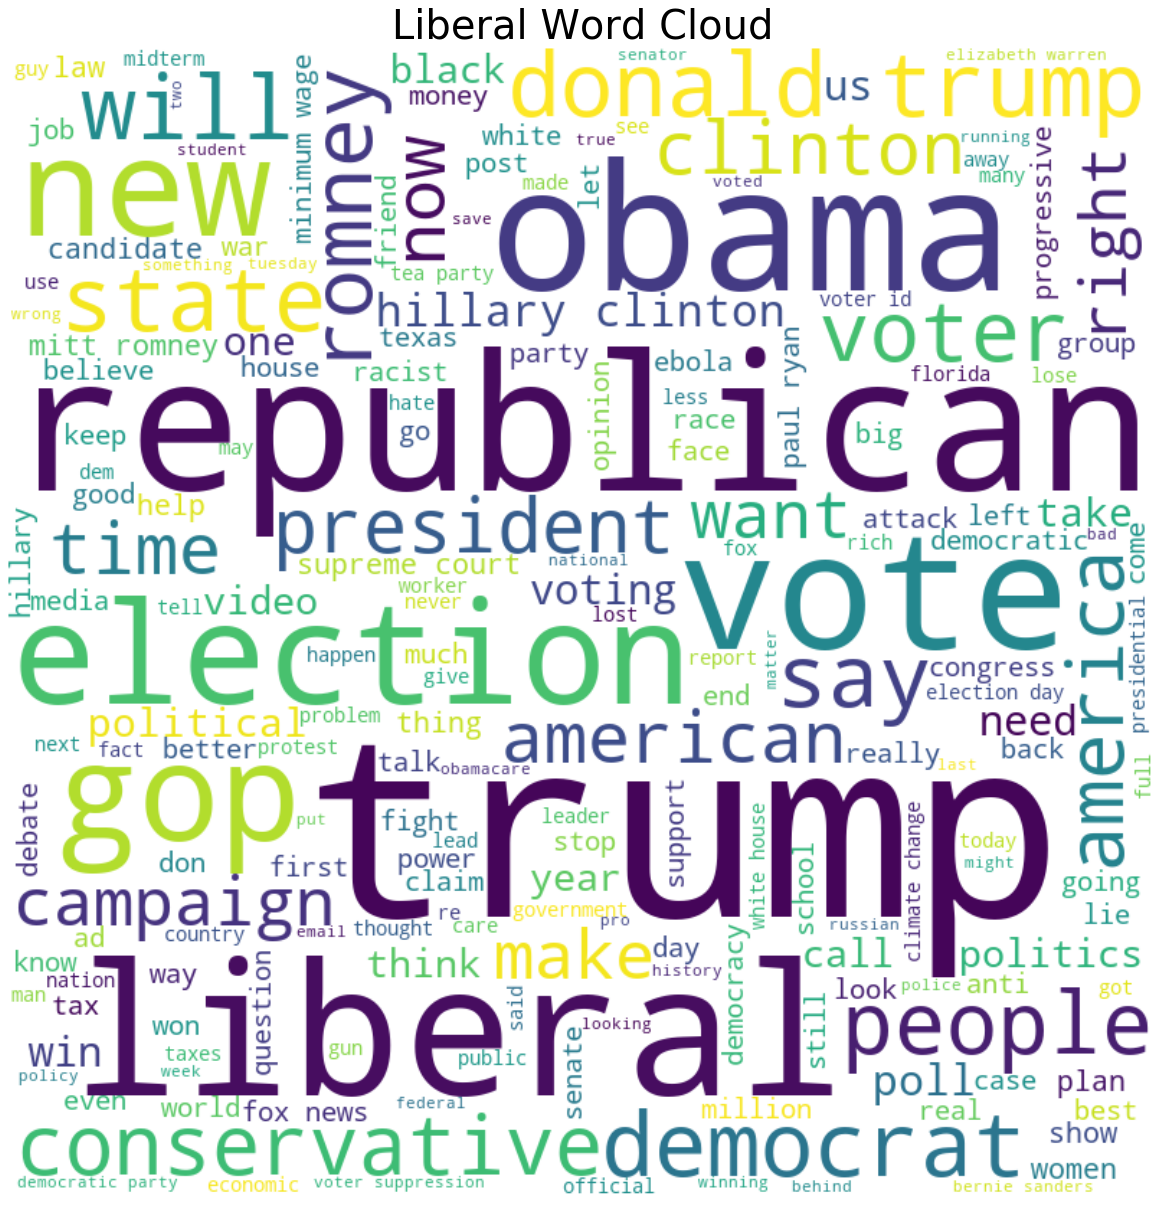

Conservative


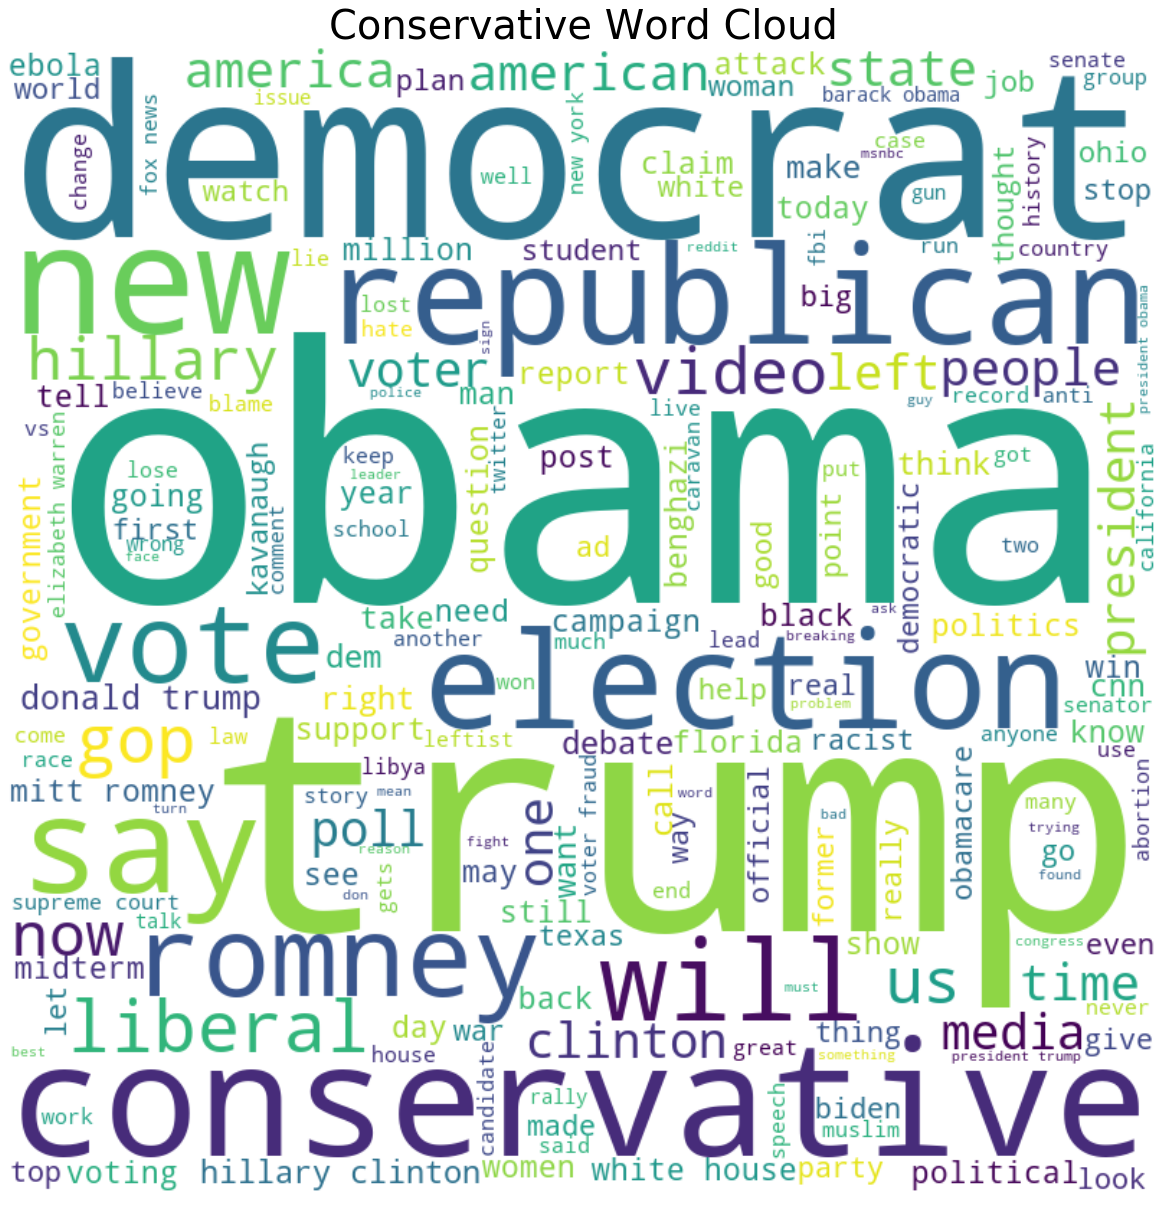

moderatepolitics


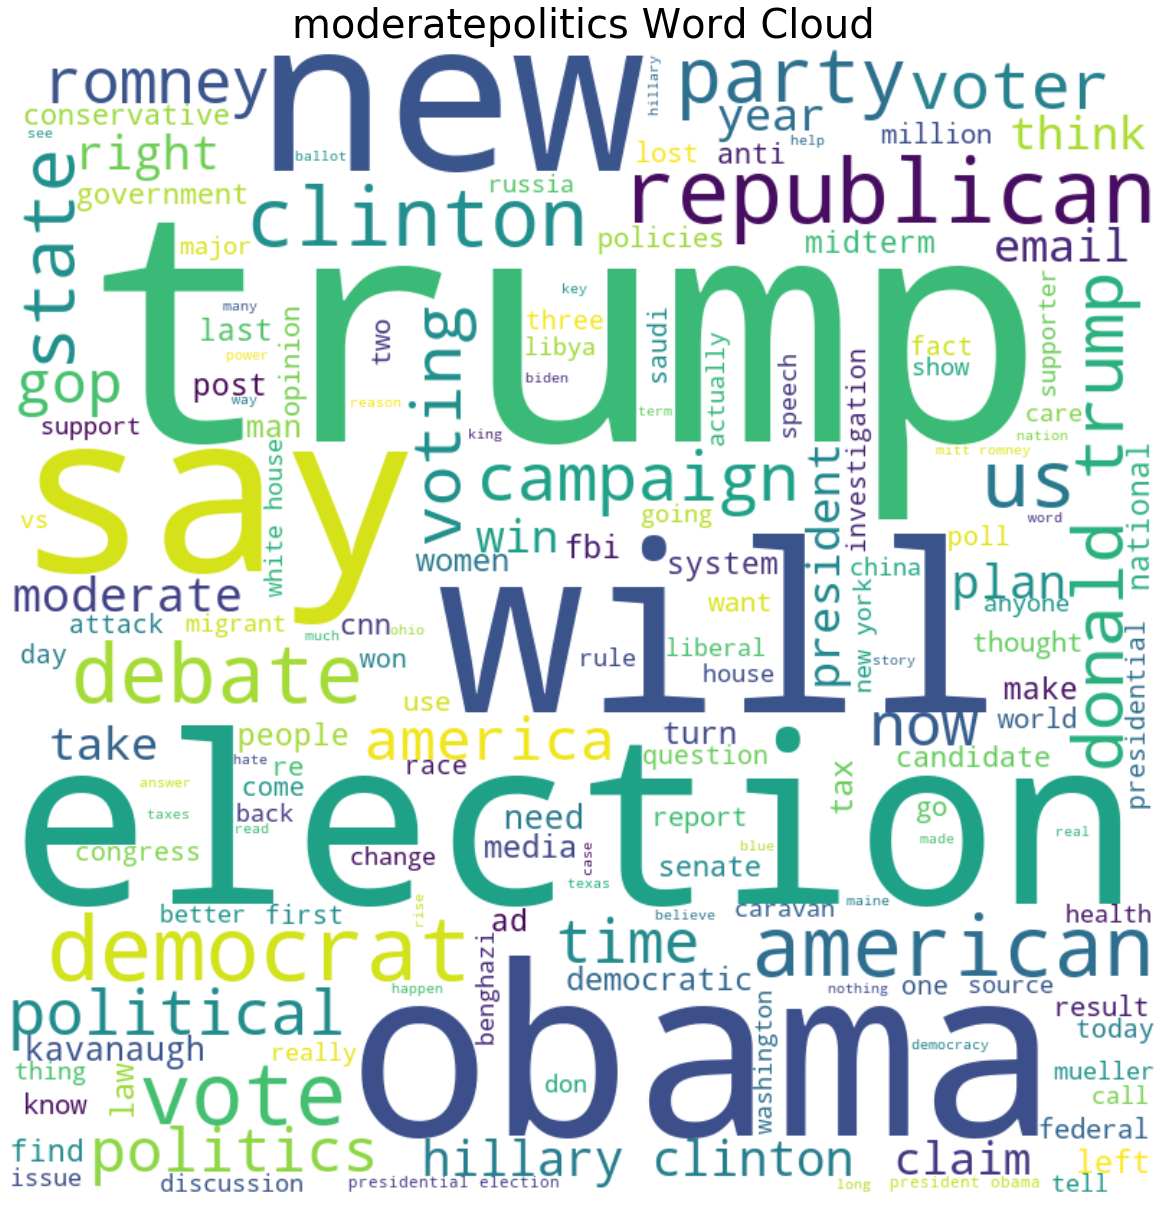

In [113]:
stopwords = set(STOPWORDS) 

for x, y in zip(word_dict['comment_words'], subreddits):    
    print(y)
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10,
                     collocations = True).generate(x) 
  
    # plot the WordCloud image                        
    plt.figure(figsize = (16, 16), facecolor = None) 
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(str(y) + " Word Cloud", fontdict = {'fontsize' : 40})
    plt.show() 